#A First Pass Implementation

In [1]:
%matplotlib inline

What’s important here is that the function approximation scheme must not only produce a good approximation to Tw, but also combine well with the broader iteration algorithm described above

One good choice from both respects is continuous piecewise linear interpolation

In [2]:
from __future__ import division  # Omit for Python 3.x
import matplotlib.pyplot as plt
import numpy as np
from numpy import log
from scipy.optimize import fminbound
from scipy import interp

In [3]:
# Primitives and grid
alpha = 0.65
beta = 0.95
grid_max = 2
grid_size = 150
grid = np.linspace(1e-6, grid_max, grid_size) #1e-6 = 0.000001

In [4]:
1e-2

0.01

In [5]:
# Exact solution
ab = alpha * beta
c1 = (log(1 - ab) + log(ab) * ab / (1 - ab)) / (1 - beta)
c2 = alpha / (1 - ab)

In [6]:
def v_star(k):
    return c1 + c2 * log(k)

In [7]:
def bellman_operator(w):
    """
    The approximate Bellman operator, which computes and returns the updated
    value function Tw on the grid points.

        * w is a flat NumPy array with len(w) = len(grid)

    The vector w represents the value of the input function on the grid
    points.
    """
    # === Apply linear interpolation to w === #
    Aw = lambda x: interp(x, grid, w)

    # === set Tw[i] equal to max_c { log(c) + beta w(f(k_i) - c)} === #
    Tw = np.empty(grid_size)
    for i, k in enumerate(grid):
        objective = lambda c: - log(c) - beta * Aw(k**alpha - c)
        c_star = fminbound(objective, 1e-6, k**alpha)
        Tw[i] = - objective(c_star)

    return Tw

In [8]:
for i, k in enumerate([3,4,5]):
    print i, k

0 3
1 4
2 5


In [11]:
f = lambda x: interp(x, [0, 0.5, 1], [0, 0.25, 1])

In [12]:
f(0.25)

0.125

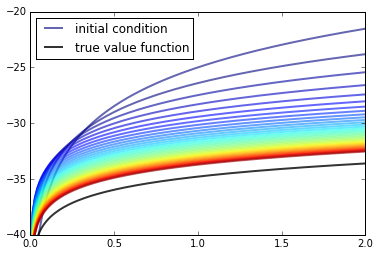

In [9]:
if __name__ == '__main__':

    w = 5 * log(grid) - 25  # An initial condition -- fairly arbitrary
    n = 35
    fig, ax = plt.subplots()
    ax.set_ylim(-40, -20)
    ax.set_xlim(np.min(grid), np.max(grid))
    lb = 'initial condition'
    ax.plot(grid, w, color=plt.cm.jet(0), lw=2, alpha=0.6, label=lb)
    for i in range(n):
        w = bellman_operator(w)
        ax.plot(grid, w, color=plt.cm.jet(i / n), lw=2, alpha=0.6)
    lb = 'true value function'
    ax.plot(grid, v_star(grid), 'k-', lw=2, alpha=0.8, label=lb)
    ax.legend(loc='upper left')

    plt.show()

In [10]:
interp?

In [13]:
run test_file.py

__main__


In [14]:
import test_file

test_file


The benefit is that we can now import the functionality in optgrowth_v0.py without necessarily generating the figure

##The Policy Function

The figure above represents the value function, and now we'd like to produce an approximate optimal policy.

#Writing Reusable Code

##The Danger of Copy and Paste

one of the most fundamental principles of code development: don’t repeat yourself

##Implementation 2

it’s convenient to wrap the model description up in a class and add the Bellman operator as a method

In [15]:
from __future__ import division  # Omit for Python 3.x
from textwrap import dedent
import numpy as np
from scipy.optimize import fminbound
from scipy import interp

In [16]:
dedent?

In [17]:
class GrowthModel(object):
    """

    This class defines the primitives representing the growth model.

    Parameters
    ----------
    f : function, optional(default=k**.65)
        The production function; the default is the Cobb-Douglas
        production function with power of .65
    beta : scalar(int), optional(default=.95)
        The utility discounting parameter
    u : function, optional(default=np.log)
        The utility function.  Default is log utility
    grid_max : scalar(int), optional(default=2)
        The maximum grid value
    grid_size : scalar(int), optional(default=150)
        The size of grid to use.

    Attributes
    ----------
    f, beta, u  : see Parameters
    grid : array_like(float, ndim=1)
        The grid over savings.

    """
    def __init__(self, f=lambda k: k**0.65, beta=0.95, u=np.log,
                 grid_max=2, grid_size=150):

        self.u, self.f, self.beta = u, f, beta
        self.grid = np.linspace(1e-6, grid_max, grid_size)

    def __repr__(self):
        m = "GrowthModel(beta={b}, grid_max={gm}, grid_size={gs})"
        return m.format(b=self.beta, gm=self.grid.max(), gs=self.grid.size)

    def __str__(self):
        m = """\
        GrowthModel:
          - beta (discount factor)                             : {b}
          - u (utility function)                               : {u}
          - f (production function)                            : {f}
          - grid bounds (bounds for grid over savings values)  : ({gl}, {gm})
          - grid points (number of points in grid for savings) : {gs}
        """
        return dedent(m.format(b=self.beta, u=self.u, f=self.f,
                               gl=self.grid.min(), gm=self.grid.max(),
                               gs=self.grid.size))

    def bellman_operator(self, w, compute_policy=False):
        """
        The approximate Bellman operator, which computes and returns the
        updated value function Tw on the grid points.

        Parameters
        ----------
        w : array_like(float, ndim=1)
            The value of the input function on different grid points
        compute_policy : Boolean, optional(default=False)
            Whether or not to compute policy function

        """
        # === Apply linear interpolation to w === #
        Aw = lambda x: interp(x, self.grid, w)

        if compute_policy:
            sigma = np.empty(len(w))

        # == set Tw[i] equal to max_c { u(c) + beta w(f(k_i) - c)} == #
        Tw = np.empty(len(w))
        for i, k in enumerate(self.grid):
            objective = lambda c: - self.u(c) - self.beta * Aw(self.f(k) - c)
            c_star = fminbound(objective, 1e-6, self.f(k))
            if compute_policy:
                # sigma[i] = argmax_c { u(c) + beta w(f(k_i) - c)}
                sigma[i] = c_star
            Tw[i] = - objective(c_star)

        if compute_policy:
            return Tw, sigma
        else:
            return Tw

    def compute_greedy(self, w):
        """
        Compute the w-greedy policy on the grid points.

        Parameters
        ----------
        w : array_like(float, ndim=1)
            The value of the input function on different grid points

        """
        Tw, sigma = self.bellman_operator(w, compute_policy=True)
        return sigma

In [42]:
import time
import numpy as np

In [19]:
#よくわからず
def _print_after_skip(skip, it=None, dist=None, etime=None):
    if it is None:
        # print initial header
        msg = "{i:<13}{d:<15}{t:<17}".format(i="Iteration",
                                             d="Distance",
                                             t="Elapsed (seconds)")
        print(msg)
        print("-" * len(msg))

        return

    if it % skip == 0:
        if etime is None:
            print("After {it} iterations dist is {d}".format(it=it, d=dist))

        else:
            # leave 4 spaces between columns if we have %3.3e in d, t
            msg = "{i:<13}{d:<15.3e}{t:<18.3e}"
            print(msg.format(i=it, d=dist, t=etime))

    return

In [20]:
def compute_fixed_point(T, v, error_tol=1e-3, max_iter=50, verbose=1,
                        print_skip=5, *args, **kwargs):
    """
    Computes and returns :math:`T^k v`, an approximate fixed point.

    Here T is an operator, v is an initial condition and k is the number
    of iterates. Provided that T is a contraction mapping or similar,
    :math:`T^k v` will be an approximation to the fixed point.

    Parameters
    ----------
    T : callable
        A callable object (e.g., function) that acts on v
    v : object
        An object such that T(v) is defined
    error_tol : scalar(float), optional(default=1e-3)
        Error tolerance
    max_iter : scalar(int), optional(default=50)
        Maximum number of iterations
    verbose : bool, optional(default=True)
        If True then print current error at each iterate.
    args, kwargs :
        Other arguments and keyword arguments that are passed directly
        to  the function T each time it is called

    Returns
    -------
    v : object
        The approximate fixed point

    """
    iterate = 0
    error = error_tol + 1 #なぜ+1するの？

    if verbose:
        start_time = time.time()
        _print_after_skip(print_skip, it=None)

    while iterate < max_iter and error > error_tol:
        new_v = T(v, *args, **kwargs)
        iterate += 1
        error = np.max(np.abs(new_v - v))

        if verbose:
            etime = time.time() - start_time
            _print_after_skip(print_skip, iterate, error, etime)

        try:
            v[:] = new_v
        except TypeError:
            v = new_v
    return v

In [26]:
gm = GrowthModel()

In [27]:
alpha, beta = 0.65, 0.95

In [28]:
true_sigma = (1 - alpha * beta) * gm.grid**alpha

optimal policy: $$ \sigma(k) = (1-\alpha \beta)k^\alpha $$

In [31]:
w = 5 * gm.u(gm.grid) #initial guess

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
5            3.315e+00      4.150e-01         


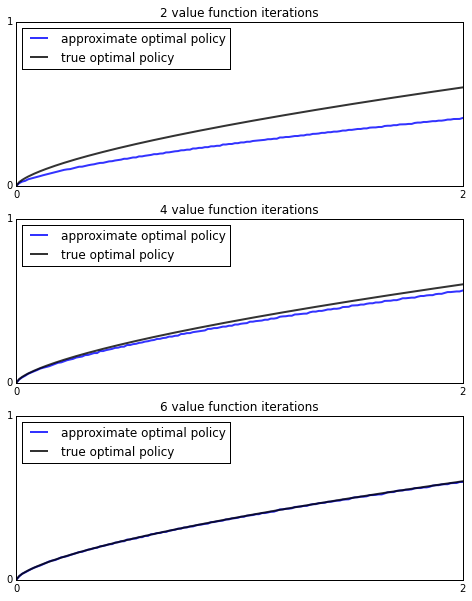

In [33]:
fig, ax = plt.subplots(3, 1, figsize=(8, 10))
for i,n in enumerate((2, 4, 6)):
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(0, 2)
    ax[i].set_yticks((0, 1))
    ax[i].set_xticks((0, 2))
    
    v_star = compute_fixed_point(gm.bellman_operator, w, max_iter=n)
    sigma = gm.compute_greedy(v_star)
    
    ax[i].plot(gm.grid, sigma, 'b-', lw=2, alpha=0.8, label='approximate optimal policy')
    ax[i].plot(gm.grid, true_sigma, 'k-', lw=2, alpha=0.8, label='true optimal policy')
    ax[i].legend(loc='upper left')
    
w = 5 * gm.u(gm.grid) - 25  # Initial condition    ax[i].set_title('{} value function iterations'.format(n))

In [51]:
import time
import numpy as np

AttributeError: 'list' object has no attribute 'time'

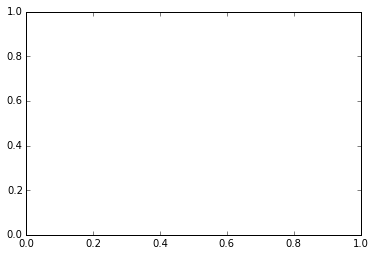

In [50]:
k_0 = 0.1 #initial condition 
gm = GrowthModel()
w = 5 * gm.u(gm.grid) - 25  # Initial condition
fig, ax = plt.subplots()
time = range(26)
capital = range(26)
capital[0] = k_0

for i, b in enumerate((0.9, 0.94, 0.98)):
    gm.beta = b
    v_star = compute_fixed_point(gm.bellman_operator, w, max_iter=20)
    sigma = gm.compute_greedy(v_star)
    
    for t in time:
        if t >= 1:
            capital[t] = sigma(capital[t-1]) 
    
    ax.plot(time, capital, alpha=0.6, label={'\$ \beta = {}\$'.format(b)})


0.182823417238
0.177746734586
0.209153541854
0.211431729135
0.224619568147
0.228659791048
0.232352088603
0.232921086465
0.233894466875
0.23395035687
0.234214576987
0.234201859786
0.234276438163
0.234264924935
0.234286817859
0.234281281473
0.234287939162
0.234285691739
0.234287776799
0.234286930707
0.234287598961
0.23428731027
0.234287550401
0.234287461895
0.139205568126
0.168027304757
0.193340899636
0.208875757519
0.221917996991
0.231552119379
0.236749696926
0.239281948759
0.240500005834
0.241082321225
0.241359890697
0.24149201301
0.241554860904
0.241584746876
0.241598956365
0.241605711878
0.241608923493
0.24161045029
0.241611176122
0.241611521178
0.241611685215
0.241611779407
0.241611846719
0.241611894821
0.313920538739
0.052836121567
0.41620248218
-0.0559886316542
0.56557545993
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


C:\Users\major0422\Anaconda\lib\site-packages\IPython\kernel\__main__.py:27: RuntimeWarning: invalid value encountered in double_scalars


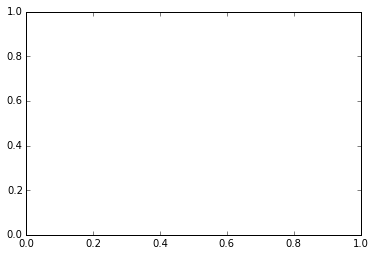

In [59]:
gm = GrowthModel()
w = 5 * gm.u(gm.grid) - 25  # Initial guess
fig, ax = plt.subplots()
time = range(1,26)
capital = np.empty(len(time))
capital[0] = 0.1 #initial condition

for i, b in enumerate((0.9, 0.94, 0.98)):
    gm.beta = b
    v_star = compute_fixed_point(gm.bellman_operator, w, max_iter=20, verbose=0)
    sigma = gm.compute_greedy(v_star)
    
    sigma_function = lambda x: interp(x, gm.grid, sigma)
    
    for t in time:
        if t >= 1 and t != len(time):
            capital[t] = gm.f(capital[t-i]) - sigma_function(capital[t-1]) 
            print capital[t]
    
    #ax.plot(time, capital, alpha=0.6, label={'\$ \beta = {}\$'.format(b)})
    

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
5            1.303e+00      3.550e-01         
10           5.142e-01      7.560e-01         
15           2.883e-01      1.173e+00         
20           1.690e-01      1.586e+00         
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
5            2.792e+00      4.000e-01         
10           2.046e+00      7.960e-01         
15           1.497e+00      1.183e+00         
20           1.099e+00      1.628e+00         
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
5            5.839e+00      4.220e-01         
10           5.247e+00      8.300e-01         
15           4.695e+00      1.230e+00         
20           4.189e+00      1.647e+00         


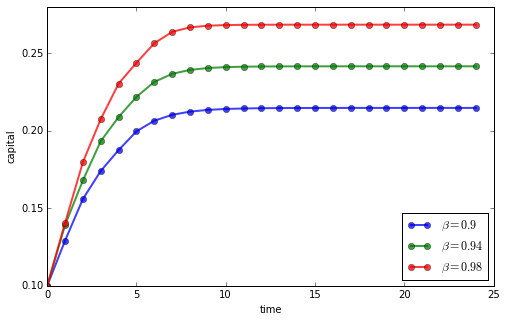

In [37]:
from scipy import interp

gm = GrowthModel() 
w = 5 * gm.u(gm.grid) - 25  # To be used as an initial condition
discount_factors = (0.9, 0.94, 0.98)
series_length = 25

fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlabel("time")
ax.set_ylabel("capital")

for beta in discount_factors:

    # Compute the optimal policy given the discount factor
    gm.beta = beta
    v_star = compute_fixed_point(gm.bellman_operator, w, max_iter=20)
    sigma = gm.compute_greedy(v_star)

    # Compute the corresponding time series for capital
    k = np.empty(series_length)
    k[0] = 0.1
    sigma_function = lambda x: interp(x, gm.grid, sigma)
    for t in range(1, series_length):
        k[t] = gm.f(k[t-1]) - sigma_function(k[t-1])
    ax.plot(k, 'o-', lw=2, alpha=0.75, label=r'$\beta = {}$'.format(beta))

ax.legend(loc='lower right')
plt.show()